In [1]:
%matplotlib inline

dataset mnist

In [39]:
from functools import reduce
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data.dataloader as dataloader
import torch.optim as optim

from torch.utils.data import TensorDataset
from torch.autograd import Variable
from torchvision import transforms
from torchvision.datasets import MNIST

from PIL import Image
import matplotlib.pyplot as plt

print(torch.__version___)

AttributeError: module 'torch' has no attribute '__version___'

In [40]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

In [43]:
batch_size = 64
train_set = MNIST('./data', train=True, download=True, transform=transforms.Compose([
    transforms.ToTensor(), # ToTensor does min-max normalization. 
]), )

test_set = MNIST('./data', train=False, download=True, transform=transforms.Compose([
    transforms.ToTensor(), # ToTensor does min-max normalization. 
]), )

# Create DataLoader
dataloader_args = dict(shuffle=True, batch_size=batch_size, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=batch_size)
train_loader = dataloader.DataLoader(train_set, **dataloader_args)
test_loader = dataloader.DataLoader(test_set, **dataloader_args)

In [44]:
def imshow_multi(images):
    f = plt.figure()
    for n, im in enumerate(images):
        im = np.clip(im, 0, 1)
        f.add_subplot(1, len(images), n+1)  # this line outputs images on top of each other
        # f.add_subplot(1, 2, n)  # this line outputs images side-by-side
        fig = plt.imshow(im, cmap='gray', vmin=0, vmax=1)
        fig.axes.get_xaxis().set_visible(False) # this is the worst api in the world
        fig.axes.get_yaxis().set_visible(False)
    plt.show()

In [45]:
img = train_set.train_data[4,:,:].numpy()
Image.fromarray(img)

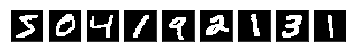

tensor([ 5,  0,  4,  1,  9,  2,  1,  3,  1])


In [47]:
imshow_multi(train_set.train_data[0:9,:,:].numpy())
print(train_set.train_labels[0:9])

## 定义神经网络


In [48]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.pool2 = nn.MaxPool2d(2)
        self.drop = nn.Dropout2d()
        self.fc1 = nn.Linear(16*4*4, 100) #TODO: 寻找自动匹配方法
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 10)

    def forward(self, x):
        """
        
        :param x: 一个batch的数据，输入结构：[batch_size, image_channel, image_width, image_height]
        :return: 前向传播结果
        """
        # 第一阶段特征提取（卷积、relu、池化）
        x = self.pool1(F.relu(self.conv1(x)))

        # 第二阶段特征提取（卷积、relu、池化）
        x = self.pool2(F.relu(self.conv2(x)))

        # dropout
        x = self.drop(x)

        # flat features 多维维空间一维化，输出也就是[batch_size, image_channel * image_width * image_height]
        x = x.view(-1, self.num_flat_features(x))
        # x = x.view(batch_size, -1)  不能用这种方法，因为最后一个epoch可能不是正好整除batch_size

        # 全连接层（fc1，fc2，fc3）
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))

        return F.log_softmax(x)

    def num_flat_features(self, x):
        feature_size = x.size()[1:]
        num_flat = reduce(lambda m, n: m*n, feature_size, 1)
        return num_flat
    
net = Net()

## 定义损失函数

In [49]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(params=net.parameters(), lr=0.01, momentum=0.9)

In [86]:
train_losses = []
test_losses = []

def train(epoch):
    net.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = net(data)  # 输出结果outputs(batch_size, class_num)
        loss = criterion(outputs, target)  
        loss.backward()
        optimizer.step()

        if batch_idx % batch_size == 0:  # print every batch_size(64) mini-batches
            print('Train Epoch[{}]: Batch[{}/{} ({:.2%}%)]  Loss: {:.6}'.format(
                epoch, batch_idx * batch_size,
                len(train_loader.dataset), batch_size * batch_idx / len(train_loader.dataset),
                loss.data[0]
            ))
            train_losses.append(loss.data[0])


def test(epoch):
    """
    整体思路是：feed forward, 计算出预测的结果，然后统计预测的结果中正确的所占比例即为精度，
    在预测中不需要backward
    :param epoch: 
    :return: 
    """
    net.eval()
    correct = 0
    test_loss = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        outputs = net(data)
        test_loss += criterion(outputs, target).data[0]
        y_pred = outputs.data.max(1)[1]
#         correct += y_pred.eq(target.data).sum()
        correct += y_pred.eq(target.view_as(y_pred)).sum().item()
        

    avg_loss = test_loss / len(test_loader)  # loss function already averages over batch size
    print('\nTest  Epoch {}: Average loss: {:.6}, Accuracy:{:.6%}\n'.format(
        epoch, avg_loss, correct / len(test_loader.dataset)
    ))


for epoch in range(1, 5):
    train(epoch)
    test(epoch)

/Users/sshuair/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:37: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/sshuair/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:17: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/Users/sshuair/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:19: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Train Epoch[1]: Batch[0/60000 (0.00%%)]  Loss: 0.730064
Train Epoch[1]: Batch[4096/60000 (6.83%%)]  Loss: 0.550426
Train Epoch[1]: Batch[8192/60000 (13.65%%)]  Loss: 0.453059
Train Epoch[1]: Batch[12288/60000 (20.48%%)]  Loss: 0.422302
Train Epoch[1]: Batch[16384/60000 (27.31%%)]  Loss: 0.600512
Train Epoch[1]: Batch[20480/60000 (34.13%%)]  Loss: 0.305183
Train Epoch[1]: Batch[24576/60000 (40.96%%)]  Loss: 0.50171
Train Epoch[1]: Batch[28672/60000 (47.79%%)]  Loss: 0.617226
Train Epoch[1]: Batch[32768/60000 (54.61%%)]  Loss: 0.383861
Train Epoch[1]: Batch[36864/60000 (61.44%%)]  Loss: 0.487687
Train Epoch[1]: Batch[40960/60000 (68.27%%)]  Loss: 0.304005
Train Epoch[1]: Batch[45056/60000 (75.09%%)]  Loss: 0.485827
Train Epoch[1]: Batch[49152/60000 (81.92%%)]  Loss: 0.432134
Train Epoch[1]: Batch[53248/60000 (88.75%%)]  Loss: 0.498942
Train Epoch[1]: Batch[57344/60000 (95.57%%)]  Loss: 0.540839


/Users/sshuair/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:34: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number



Test  Epoch 1: Average loss: 0.128359, Accuracy:96.170000%

Train Epoch[2]: Batch[0/60000 (0.00%%)]  Loss: 0.132041
Train Epoch[2]: Batch[4096/60000 (6.83%%)]  Loss: 0.167896
Train Epoch[2]: Batch[8192/60000 (13.65%%)]  Loss: 0.17117
Train Epoch[2]: Batch[12288/60000 (20.48%%)]  Loss: 0.138968
Train Epoch[2]: Batch[16384/60000 (27.31%%)]  Loss: 0.218223
Train Epoch[2]: Batch[20480/60000 (34.13%%)]  Loss: 0.136549
Train Epoch[2]: Batch[24576/60000 (40.96%%)]  Loss: 0.155736
Train Epoch[2]: Batch[28672/60000 (47.79%%)]  Loss: 0.0813156
Train Epoch[2]: Batch[32768/60000 (54.61%%)]  Loss: 0.16703
Train Epoch[2]: Batch[36864/60000 (61.44%%)]  Loss: 0.118343
Train Epoch[2]: Batch[40960/60000 (68.27%%)]  Loss: 0.130953
Train Epoch[2]: Batch[45056/60000 (75.09%%)]  Loss: 0.286894
Train Epoch[2]: Batch[49152/60000 (81.92%%)]  Loss: 0.16719
Train Epoch[2]: Batch[53248/60000 (88.75%%)]  Loss: 0.0331202
Train Epoch[2]: Batch[57344/60000 (95.57%%)]  Loss: 0.220235

Test  Epoch 2: Average loss: 0.0

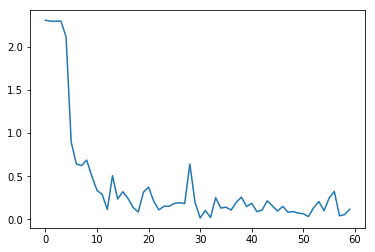

In [38]:
plt.plot(train_losses)

In [ ]:
torch.view()

In [94]:
a = test_set.test_data[0,:,:]
a = torch.unsqueeze(a,0)
a = torch.unsqueeze(a,0)
a = a.float()


'torch.FloatTensor'

In [95]:

net(a)

torch.Size([1, 1, 28, 28])


/Users/sshuair/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:37: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


tensor([[-4436.8516, -4436.8516, -2476.6855, -2268.2866, -4436.8516,
         -4436.8516, -4436.8516,     0.0000, -3360.7656, -3150.9802]])

In [23]:
y_pred.eq(target.data).cpu().sum()

NameError: name 'y_pred' is not defined

In [ ]:
for epoch in range(2):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.data[0]
        if i % 10 == 0:
            print('[epoch{epoch}, {batch}] loss: {loss}'
                  .format(epoch=epoch + 1, batch=i + 1, loss=running_loss / 2000))
            running_loss = 0.0
print('done')




You just have to define the ``forward`` function, and the ``backward``
function (where gradients are computed) is automatically defined for you
using ``autograd``.
You can use any of the Tensor operations in the ``forward`` function.

The learnable parameters of a model are returned by ``net.parameters()``



In [4]:
params = list(net.parameters())
print(len(params))
print(params[0].size())  # conv1's .weight

10
torch.Size([6, 1, 5, 5])


Let try a random 32x32 input
Note: Expected input size to this net(LeNet) is 32x32. To use this net on
MNIST dataset, please resize the images from the dataset to 32x32.



In [5]:
input = torch.randn(1, 1, 32, 32)
out = net(input)
print(out)

tensor(1.00000e-02 *
       [[ 5.3677,  1.8602, -0.8477, -1.8422,  5.4403,  8.7360,  5.9282,
         -0.2987, -3.9163,  7.7429]])


Zero the gradient buffers of all parameters and backprops with random
gradients:



In [6]:
net.zero_grad()
out.backward(torch.randn(1, 10))

<div class="alert alert-info"><h4>Note</h4><p>``torch.nn`` only supports mini-batches. The entire ``torch.nn``
    package only supports inputs that are a mini-batch of samples, and not
    a single sample.

    For example, ``nn.Conv2d`` will take in a 4D Tensor of
    ``nSamples x nChannels x Height x Width``.

    If you have a single sample, just use ``input.unsqueeze(0)`` to add
    a fake batch dimension.</p></div>

Before proceeding further, let's recap all the classes you’ve seen so far.

**Recap:**
  -  ``torch.Tensor`` - A *multi-dimensional array* with support for autograd
     operations like ``backward()``. Also *holds the gradient* w.r.t. the
     tensor.
  -  ``nn.Module`` - Neural network module. *Convenient way of
     encapsulating parameters*, with helpers for moving them to GPU,
     exporting, loading, etc.
  -  ``nn.Parameter`` - A kind of Tensor, that is *automatically
     registered as a parameter when assigned as an attribute to a*
     ``Module``.
  -  ``autograd.Function`` - Implements *forward and backward definitions
     of an autograd operation*. Every ``Tensor`` operation, creates at
     least a single ``Function`` node, that connects to functions that
     created a ``Tensor`` and *encodes its history*.

**At this point, we covered:**
  -  Defining a neural network
  -  Processing inputs and calling backward

**Still Left:**
  -  Computing the loss
  -  Updating the weights of the network

Loss Function
-------------
A loss function takes the (output, target) pair of inputs, and computes a
value that estimates how far away the output is from the target.

There are several different
`loss functions <http://pytorch.org/docs/nn.html#loss-functions>`_ under the
nn package .
A simple loss is: ``nn.MSELoss`` which computes the mean-squared error
between the input and the target.

For example:



In [7]:
output = net(input)
target = torch.arange(1, 11)  # a dummy target, for example
target = target.view(1, -1)  # make it the same shape as output
criterion = nn.MSELoss()

loss = criterion(output, target)
print(loss)

tensor(38.1824)


Now, if you follow ``loss`` in the backward direction, using its
``.grad_fn`` attribute, you will see a graph of computations that looks
like this:

::

    input -> conv2d -> relu -> maxpool2d -> conv2d -> relu -> maxpool2d
          -> view -> linear -> relu -> linear -> relu -> linear
          -> MSELoss
          -> loss

So, when we call ``loss.backward()``, the whole graph is differentiated
w.r.t. the loss, and all Tensors in the graph that has ``requres_grad=True``
will have their ``.grad`` Tensor accumulated with the gradient.

For illustration, let us follow a few steps backward:



In [8]:
print(loss.grad_fn)  # MSELoss
print(loss.grad_fn.next_functions[0][0])  # Linear
print(loss.grad_fn.next_functions[0][0].next_functions[0][0])  # ReLU

Backprop
--------
To backpropagate the error all we have to do is to ``loss.backward()``.
You need to clear the existing gradients though, else gradients will be
accumulated to existing gradients.


Now we shall call ``loss.backward()``, and have a look at conv1's bias
gradients before and after the backward.



In [9]:
net.zero_grad()     # zeroes the gradient buffers of all parameters

print('conv1.bias.grad before backward')
print(net.conv1.bias.grad)

loss.backward()

print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)

conv1.bias.grad before backward
tensor([ 0.,  0.,  0.,  0.,  0.,  0.])
conv1.bias.grad after backward
tensor([-0.0296, -0.1084, -0.0346, -0.0628, -0.0655,  0.0212])


Now, we have seen how to use loss functions.

**Read Later:**

  The neural network package contains various modules and loss functions
  that form the building blocks of deep neural networks. A full list with
  documentation is `here <http://pytorch.org/docs/nn>`_.

**The only thing left to learn is:**

  - Updating the weights of the network

Update the weights
------------------
The simplest update rule used in practice is the Stochastic Gradient
Descent (SGD):

     ``weight = weight - learning_rate * gradient``

We can implement this using simple python code:

.. code:: python

    learning_rate = 0.01
    for f in net.parameters():
        f.data.sub_(f.grad.data * learning_rate)

However, as you use neural networks, you want to use various different
update rules such as SGD, Nesterov-SGD, Adam, RMSProp, etc.
To enable this, we built a small package: ``torch.optim`` that
implements all these methods. Using it is very simple:



In [10]:
import torch.optim as optim

# create your optimizer
optimizer = optim.SGD(net.parameters(), lr=0.01)

# in your training loop:
optimizer.zero_grad()   # zero the gradient buffers
output = net(input)
loss = criterion(output, target)
loss.backward()
optimizer.step()    # Does the update

.. Note::

      Observe how gradient buffers had to be manually set to zero using
      ``optimizer.zero_grad()``. This is because gradients are accumulated
      as explained in `Backprop`_ section.

